In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import os
from astropy import wcs
from astropy.table import Table, hstack, Column
from astropy.utils.console import ProgressBar
import pandas as pd

In [2]:
### load constants and functions
# Image information and assumptions
distance        = 8340. # distance to GC; Reid et al. 2014
#Temp            = 20.0
Wave            = (3.0e8/226.e9)
Wave0           = 1.3e-3
k0              = 0.899
nu              = 3.e08/Wave
nu0             = 3.e08/Wave0
beta            = 1.75
Kappag2d        = k0*((nu/nu0)**beta)
g2d             = 100.0
Kappa           = Kappag2d / g2d
mu              = 2.8 # express everything in H2

dustTemp = 20

# Constants
G = 6.67408e-11
msun = 1.989e33
mh = 1.6737236e-27
pc2cm = 3.08567758e18
as2persr = 4.25e10 
percm2perm = 1.0e6
JyperSr_to_JyperPix = (3.0462*(10**-4))*((0.00013888888888)**2)
JyperSr_to_Jyperassqr = ((np.pi*180.)**(-2))*(3600**(-1))
hplanck = 6.63e-34
clight = 2.99792e8
kboltzmann = 1.381e-23
sin1yr = 3.15569e7
arcsec2pc = distance/((360./(2.*np.pi))*60.*60.)

def planck_wave( Wave, Temp ):

    # Planck function using wavelength

    planck_conv_wave = 1.e-26 * clight / Wave**2.0

    planck = ((2.0*hplanck*clight**2.0)/(Wave**5.0))*(1.0/(np.exp((hplanck*clight)/(Wave*kboltzmann*Temp))-1.0))
    planck = planck/planck_conv_wave

    return planck

def mass_calc_submm( Wave, Temp, Kappa, Integrated_Flux, Obj_Dist ):

    Obj_Dist = Obj_Dist * pc2cm
    #from planck_func import planck_wave
    B = planck_wave( Wave, Temp )
    Mass = (Obj_Dist**2. * Integrated_Flux) / ( Kappa * B )
    Mass = Mass / msun
    return Mass

def radius_from_mass_const_col_density(Mass_solar,col_dens):
    #print Mass_solar
    Mass = Mass_solar * (msun/1000.0)
    #print Mass
    col_dens = col_dens * (10**4) #convert from cm^-2 to m^-2

    Radius_sqrd = (Mass / (mu * mh * col_dens)) / (np.pi)
    #print Radius_cubed
    Radius_cm = Radius_sqrd**(1./2.)
    #print Radius_cm
    Radius_pc = Radius_cm / (pc2cm/100)
    return Radius_pc
   
    
def mass_from_radius_const_col_density(Radius_pc,col_dens):
    Radius_cm = Radius_pc * (pc2cm)#/100) 
    Radius_sqrd = Radius_cm**2
    Mass = Radius_sqrd * (np.pi) * (mu * mh * col_dens)
    col_dens = col_dens * (10**4) #convert from cm^-2 to m^-2
    Mass_solar = Mass / (msun/1000.0)
    return Mass_solar

In [3]:
### Load tables

targetname = '_rms1e7_dv3_dd1_dp50_pp6_pm2_gal_5-28-19.fits'
target_id = targetname
path = os.path.expanduser('/Users/hph/cmzoom_catalog/catalog_5-28-19/')
catalog = Table.read(path+'master_tab'+targetname)
df = catalog.to_pandas()
tff_spherical = catalog['tff']
mass = catalog['mass']
mass_bgsub = catalog['mass_bgsub']
r_eff_as = catalog['r_eff']
r_eff_pc = r_eff_as * arcsec2pc
flux_integrated = catalog['flux_integrated']
noise_JySr = catalog['noise']
noise_Jyas = noise_JySr / as2persr
noise = noise_Jyas * catalog['area_exact']
flux_integrated = catalog['flux_integrated']
noise_mass = mass_calc_submm(Wave, dustTemp, Kappa, noise, distance)

In [4]:
catalog

obj_ID,index,area_ellipse,area_exact,flux_integrated,major_sigma,minor_sigma,position_angle,radius,glon,glat,r_eff,noise,flux_integrated_bgsub,npix,mean_cont_flux,min_flux_integrated,peak_cont_flux,min_cont_flux,ColumnDensity,mass,N,r_eff_pc,Sigma,n,rho,tff,glon_0,mass_bgsub,YSO,water,methanol,H2CO_gas_temp,Total_luminosity,Cool_luminosity,Warm_luminosity,Cool_dust_temp,24micron,70micron,overdensity
bytes21,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
G359.615-0.243c,15,15.93642962736847,44.99999999424,0.06711277017465443,3.0666186425417155,1.1932551629971622,49.989873876331835,1.9129188503844723,-0.3760651010894094,-0.24710558434732224,3.7846987827880194,18914213.591463517,0.027139740230957166,180,63451649.699837305,0.039973029943697266,138673398.29364792,37792110.252965584,6.8058127e+22,109.17243059895792,1.4456421197345135e+23,0.15302847064777161,0.24196053329536812,105062.81506253393,4.923691165472759e-16,94869.17736580166,0.3760651010894094,44.148250759538456,0.0,0.0,0.0,58.688456392085335,5749.8013015278475,3224.7710159837957,2525.0302855440523,19.806228637695312,0.0,0.0,2.1241285588708987
G359.615-0.243a,20,50.27924382752406,259.249999966816,2.092034161041695,3.4324496525090025,3.363462780211621,176.63735384078174,3.3977811364424784,-0.3853654338704473,-0.24323223654332535,9.084153124126923,12875155.131009452,1.7412478515626204,1037,343320924.42923653,0.3507863094790745,1726650427.7703958,57566583.85239814,1.4556968e+23,3403.114692816353,1.799998136020899e+24,0.3673037511036135,3.012699360214189,236839.0240518991,1.1099285790785672e-15,63186.313787548344,0.3853654338704473,2832.4901465935286,0.0,1.0,1.0,94.81467080778177,8272.579483796391,5656.421864614707,2616.1576191816835,20.977277755737305,0.0,1.0,12.365199543858427
G359.615-0.243b,21,11.752823560482662,34.749999995551995,0.07516242316464358,2.1722544885214017,1.2423202874156973,115.3938641262996,1.642752513472418,-0.3820674204332022,-0.24458589102278241,3.3258485448785673,14746766.20838899,0.028137800631797154,139,92022966.72864848,0.04702462253284643,170279866.42564774,57572766.26793404,8.594786e+22,122.2668115954254,1.7751331551450054e+23,0.13447556744633804,0.2971082254908657,173392.8551894198,8.125927986453602e-16,73847.203247259,0.3820674204332022,45.77179691268803,1.0,0.0,0.0,61.040707249544745,7480.17341576973,4643.481026483585,2836.692389286145,20.581090927124023,0.0,0.0,2.0653605716475694
G0.316-0.201c,67,25.211140251189796,71.749999990816,0.09709159218501653,3.7773144898767193,1.5325385515383037,45.00550272078365,2.406009159795597,0.32231843780317815,-0.20319075749052307,4.778988839782284,18081927.04848292,0.04615952921408237,287,57571823.33609517,0.05093206297093417,121963054.86846082,30200626.321560707,4.6472244e+22,157.93901938448215,1.2714401704931376e+23,0.1932310588944464,0.21280394193423882,75493.82037313725,3.5379620867550574e-16,111916.45611522779,-0.32231843780317815,75.08776625507436,0.0,0.0,0.0,nan,10910.650468945913,3384.530054195106,7526.120414750806,22.33585548400879,0.0,0.0,2.7359130274789965
G0.316-0.201e,72,4.899790680031681,15.499999998016,0.031337927480191145,1.3372103455354436,0.8413561308392382,-173.24764493631287,1.0606932272989686,0.3147805618240951,-0.20344117713084614,2.221216611503081,14706482.50754292,0.00900671579951938,62,86017900.74476515,0.022331211680671766,126709999.80412915,61295300.420524105,4.0083406e+22,50.9774474223446,1.3209261110087883e+23,0.08981147524383588,0.2210865205851629,242680.7690036943,1.1373054849733686e-15,62421.17939994702,-0.3147805618240951,14.651236314469868,0.0,0.0,0.0,nan,21713.243674220048,5814.3339246822425,15898.909749537808,25.53567314147949,0.0,0.0,3.295443801179201
G0.316-0.201a,75,48.59408250416192,208.74999997327998,1.1099026573314

In [5]:
### december 2018 SF tracers from Ash
# an = catalog['an2011_allysos']
# caswell = catalog['caswell2012_allmmb']
# gutermuth = catalog['gutermuth2015_all24m']
# immer = catalog['immer2012_allysos']
# molinari = catalog['molinari2016_all70m']
# walsh = catalog['walsh2014_allhops']
# yusefZadeh = catalog['jusefZadeh2009_allysos']

# sum_ir = np.array(gutermuth)+np.array(molinari)
# ir_24 = np.array(gutermuth)
# ir_70 = np.array(molinari)
# sum_ysos = np.array(an)+np.array(immer)+np.array(yusefZadeh)
# sum_masers = np.array(caswell)+np.array(walsh)

In [4]:
sum_masers=catalog['water']+catalog['methanol']
sum_ir = catalog['24micron']+catalog['70micron']
sum_ysos = catalog['YSO']

In [5]:
### normalize sums
for i in range(len(sum_masers)):
    if sum_masers[i]>0: sum_masers[i]=1
    if sum_ir[i]>0: sum_ir[i]=1
    if sum_ysos[i]>0: sum_ysos[i]=1

(3, 4)
water
-----
  0.0
  1.0
  1.0
  0.0
  0.0
  1.0
  0.0
  0.0
  0.0
  0.0
  ...
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
Length = 152 rows
1


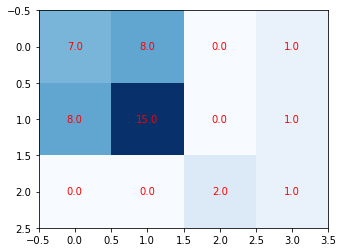

In [10]:
### building comparison matrix for all permutations of Masers, YSO+IR and HII        
all_list = [sum_masers,sum_ir,sum_ysos]

### initialize matrix
comp_matrix = np.zeros((len(all_list),len(all_list)+1),dtype=float)
print(comp_matrix.shape)

all_together = sum((all_list[0]>0) & (all_list[1]>0) & (all_list[2]>0))
any_sf = all_list[0]+all_list[1]+all_list[2]
any_sf[any_sf > 0]=1
print(any_sf)

print(all_together)

# for i in range(3):
#     comp_matrix[i,3] = all_together
#     for j in range(3):
#         num = sum((all_list[i]>0) & (all_list[j]>0) )
#         comp_matrix[i,j]=num

comp_matrix[0,0] = sum((all_list[0]>0) & (all_list[1]==0) & (all_list[2]==0))
comp_matrix[1,1] = sum((all_list[1]>0) & (all_list[0]==0) & (all_list[2]==0))
comp_matrix[2,2] = sum((all_list[2]>0) & (all_list[0]==0) & (all_list[1]==0))
comp_matrix[0,1] = sum((all_list[0]>0) & (all_list[1]>0) & (all_list[2]==0))
comp_matrix[0,2] = sum((all_list[0]>0) & (all_list[2]>0) & (all_list[1]==0))
comp_matrix[1,2] = sum((all_list[1]>0) & (all_list[2]>0) & (all_list[0]==0))
comp_matrix[0,3] = sum((all_list[0]>0) & (all_list[1]>0) & (all_list[2]>0))
comp_matrix[1,0], comp_matrix[2,0], comp_matrix[2,1] = comp_matrix[0,1], comp_matrix[0,2], comp_matrix[1,2]
comp_matrix[1,3] = comp_matrix[0,3]
comp_matrix[2,3] = comp_matrix[0,3]

ax=plt.gca()
for i in range(len(comp_matrix[:,0])):
    for j in range(len(comp_matrix[0,:])):
        text = ax.text(j, i, comp_matrix[i, j],
                       ha="center", va="center", color="red")

plt.imshow(comp_matrix,cmap='Blues')
plt.show()

0
18
73


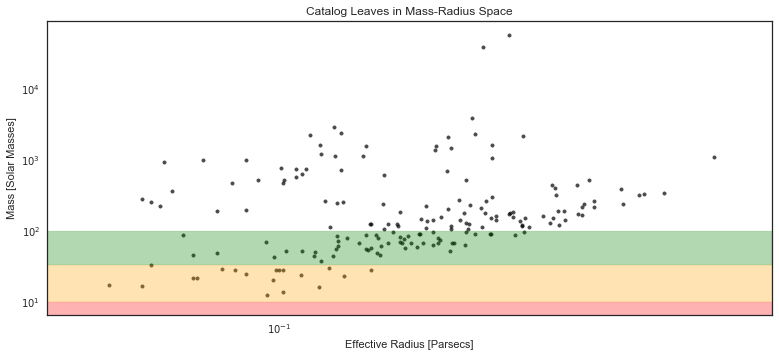

In [23]:
plt.close()
plt.rcParams.update({'font.size': 12}) #set fontsize
mrfig = plt.figure(3,figsize=(13,6))
mrfig.clf()
ax = mrfig.gca()
plt.xlabel('Effective Radius [Parsecs]')
plt.ylabel('Mass [Solar Masses]')
ax.set_title('Catalog Leaves in Mass-Radius Space')
pcolor = 'tomato'

### conditions
none_cond = (sum_masers+sum_ir+sum_ysos) == 0
maser_cond = (sum_masers>0)
ir_cond = (sum_ir>0)
ir_24_cond = (ir_70>0)
ir_70_cond = (ir_24>0)
yso_cond= (sum_ysos>0)
#HII_cond = (all_HII>0)

ax.scatter(r_eff_pc, mass,s=50, 
           color='black',marker='.',alpha=.7)#,label='No SF tracers')
# ax.scatter(r_eff_pc[maser_cond], mass[maser_cond],s=60, 
#            color='forestgreen',marker='o',alpha=.4,label='Maser')
# ax.scatter(r_eff_pc[yso_cond], mass[yso_cond],s=40, 
#            color='red',marker='*',alpha=1.,label='YSO')
# ax.scatter(r_eff_pc[ir_24_cond], mass[ir_24_cond],s=30, 
#            color='blue',marker='s',alpha=.3,label='IR 24m')

## ax.scatter(r_eff_pc[ir_70_cond], mass[ir_70_cond],s=50, 
##            color='orange',marker='s',alpha=.5,label='IR 70m')

#ax.scatter(r_eff_pc[HII_cond], mass[HII_cond],s=60, 
#           color='forestgreen',marker='s',alpha=.3,label='Maser, IR/YSO, and HII regions')

#ax.errorbar(x=r_eff_pc, y=mass, yerr=noise_mass, ls='none',color=pcolor,alpha=1.)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(4e-2,0.7)

plt.gcf().subplots_adjust(bottom=0.2) #make room for x-axis
mass_bin = np.array([min(mass),max(mass)])
#print mass_bin.shape
radius_vals = radius_from_mass_const_col_density(mass_bin,2.1*10**23)
#print radius_vals.shape
#ax.plot(radius_vals,mass_bin,color='navy',
#        label='Constant Column Density of 2.1*10$^{23}$ cm$^{-2}$',linestyle='-',alpha=0.5)

ax.fill_between(np.linspace(4e-2,0.7,10),10,color='red',alpha= 0.3)
ax.fill_between(np.linspace(4e-2,0.7,10),10,y2=33,color='orange',alpha= 0.3)
ax.fill_between(np.linspace(4e-2,0.7,10),33,y2=100,color='green',alpha= 0.3)

print len(np.where(mass<10)[0])
print len(np.where(mass<33)[0])
print len(np.where(mass<100)[0])


#legend = plt.legend(loc='upper left', shadow=False, fontsize=14)#'x-large')

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
#plt.savefig(figure_path + 'no_line_mass_radius'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()

/Users/hph/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:109: RuntimeWarning: invalid value encountered in divide


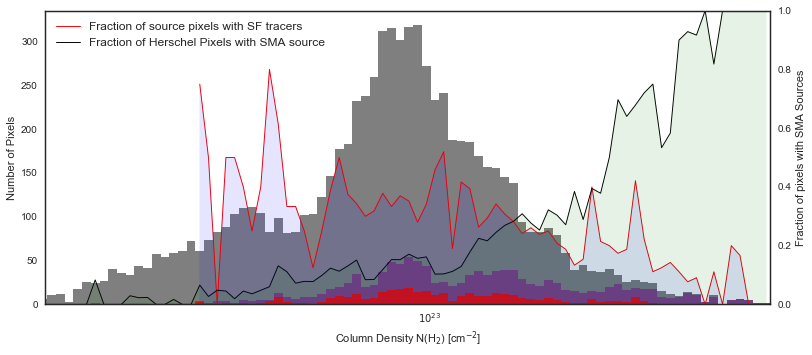

In [22]:
### Herschel pdf but with SF tracers
import reproject
import pyregion

sum_tracers = sum_masers + sum_ir + sum_ysos

sf_cond = (sum_tracers > 0)
nsf_cond = (sum_tracers ==0)

### Make figure of column density 
column_file = os.path.join(path, 'column_properunits_conv36_source_only.fits')
sma_file = os.path.join(path, 'Continuum_mosaic_current_no_sgra_no_IHMSFR.fits')
sma_mosaic = fits.open(sma_file)
sma_orig = sma_mosaic[0].data
sma_observed = np.isfinite(sma_orig)

# column density file handle
column_fh = fits.open(column_file)
column_masked = column_fh[0].data

smaobserved_projto_herschel,_ = reproject.reproject_interp((sma_observed,
                                                            wcs.WCS(sma_mosaic[0].header).celestial),
                                                            column_fh[0].header)
smaobserved_projto_herschel[np.isnan(smaobserved_projto_herschel)] = 0
smaobserved_projto_herschel = smaobserved_projto_herschel.astype('bool')
colwcs = wcs.WCS(column_fh[0].header)

pix = colwcs.wcs_world2pix(catalog['glon'], catalog['glat'], 0)
pix_nsf = colwcs.wcs_world2pix(catalog['glon'][nsf_cond], catalog['glat'][nsf_cond], 0)
pix_sf = colwcs.wcs_world2pix(catalog['glon'][sf_cond], catalog['glat'][sf_cond], 0)

column_dens = column_fh[0].data[pix[1].astype('int'), pix[0].astype('int')]
column_dens_nsf = column_fh[0].data[pix_nsf[1].astype('int'), pix_nsf[0].astype('int')]
column_dens_sf = column_fh[0].data[pix_sf[1].astype('int'), pix_sf[0].astype('int')]

column_masked[~smaobserved_projto_herschel] = np.nan


sb2_mask = pyregion.open(os.path.join('/Users/hph/Dropbox/CMZoom_Data/prototype_catalog/', 'sgrb2mask.reg')).get_mask(column_fh[0])

colmin = np.nanmin(column_masked[~sb2_mask])
colmax = np.nanmax(column_masked[~sb2_mask])


smasourcemask = np.zeros_like(smaobserved_projto_herschel, dtype='bool')
smasourcemask_nsf = np.zeros_like(smaobserved_projto_herschel, dtype='bool')
smasourcemask_sf = np.zeros_like(smaobserved_projto_herschel, dtype='bool')

# for each source, "mask" a region that is within a herschel beam as "this region contains a source"
herschel_beamsize_pixels = (25*u.arcsec / np.mean(wcs.utils.proj_plane_pixel_scales(colwcs)*u.deg)).decompose()

# make a small radial mask
npix = int(np.ceil(herschel_beamsize_pixels))
yy,xx = np.indices([npix*2]*2, dtype='float')
rad = ((yy-npix+0.5)**2 + (xx-npix+0.5)**2)**0.5
radmask = rad < herschel_beamsize_pixels

for row,(cx,cy) in zip(catalog, zip(*pix)):
    cy = int(np.round(cy))
    cx = int(np.round(cx))
    smasourcemask[cy-npix:cy+npix,cx-npix:cx+npix][radmask] = True
    
for row,(cx,cy) in zip(catalog[nsf_cond], zip(*pix_nsf)):
    cy = int(np.round(cy))
    cx = int(np.round(cx))
    smasourcemask_nsf[cy-npix:cy+npix,cx-npix:cx+npix][radmask] = True
    

for row,(cx,cy) in zip(catalog[sf_cond], zip(*pix_sf)):
    cy = int(np.round(cy))
    cx = int(np.round(cx))
    smasourcemask_sf[cy-npix:cy+npix,cx-npix:cx+npix][radmask] = True
    
### plotting now
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16}) #set fontsize

# Plot Histogram
plt.rcParams.update({'font.size': 24}) #set fontsize
histfig = plt.figure(3,figsize=(13,6))
histfig.clf()
ax = histfig.gca()
plt.ylabel('Number of Pixels')
plt.xlabel('Column Density N(H$_2$) [cm$^{-2}$]')
#plt.legend(loc='upper left', shadow=False, fontsize=18)

#bins = np.logspace(22.9,23.9,100)
linbins = np.linspace(colmin, colmax,100)
logbins = np.logspace(np.log10(colmin), np.log10(colmax),100)
### histogram non sources
h1,l1,p1 = ax.hist(column_masked[np.isfinite(column_masked) & ~sb2_mask],
                   logbins, color='black',alpha=0.5, log=False,
                   label='Full cloud')
### histogram all sources
h2,l2,p2 = ax.hist(column_masked[smasourcemask & np.isfinite(column_masked) &
                                 ~sb2_mask], logbins, alpha=0.5, log=False, color='darkmagenta',
                   label='SMA Sources')
### histogram non sf 
#h3,l3,p3 = ax.hist(column_masked[smasourcemask_nsf & np.isfinite(column_masked) &
#                                 ~sb2_mask], logbins, alpha=.7, log=False, color='orange',
#                   label='SMA Sources')
### histogram sf
h4,l4,p4 = ax.hist(column_masked[smasourcemask_sf & np.isfinite(column_masked) &
                                 ~sb2_mask], logbins, alpha=.9, log=False, color='red',
                   label='SMA Sources')

ax3 = ax.twinx()

ratio_to_plot1 = h4/h2
ratio_to_plot2 = h2/h1
midpts = (l1[:-1] + l1[1:])/2.
line_frac = ax3.plot(midpts, ratio_to_plot, linestyle='-', color='red', linewidth=0.95, zorder=-21,label='Fraction of source pixels with SF tracers')
ax3.set_ylabel("Fraction of pixels with SMA Sources")
ax3.set_ylim(0,1)
fill = ax3.fill_between(midpts,ratio_to_plot, color='blue',alpha=0.1)

line_frac = ax3.plot(midpts, ratio_to_plot2, linestyle='-', color='k', linewidth=0.95, zorder=-21,label='Fraction of Herschel Pixels with SMA source')
fill = ax3.fill_between(midpts,ratio_to_plot2, color='green',alpha=0.1)

ax3.set_label('Fraction of pixels with SMA Sources')
#ax3.legend(line_frac,'Fraction of pixels with SMA Sources')
ax3.legend(loc='upper left', shadow=False, fontsize=12)




ax.set_xscale("log")
#ax.set_xlim(10**22.9, 10**23.9)
ax.set_xlim(2e22, colmax)
#ax.set_ylim(1,380)
#ax.set_ylim(1,5000)
plt.gcf().subplots_adjust(bottom=0.2) #make room for x-axis



# Save figure
# Need to save it as a PDF, otherewise, lose transparency
#plt.savefig(figure_path + 'column_histograms_log'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')

plt.show()

183
176

176
176


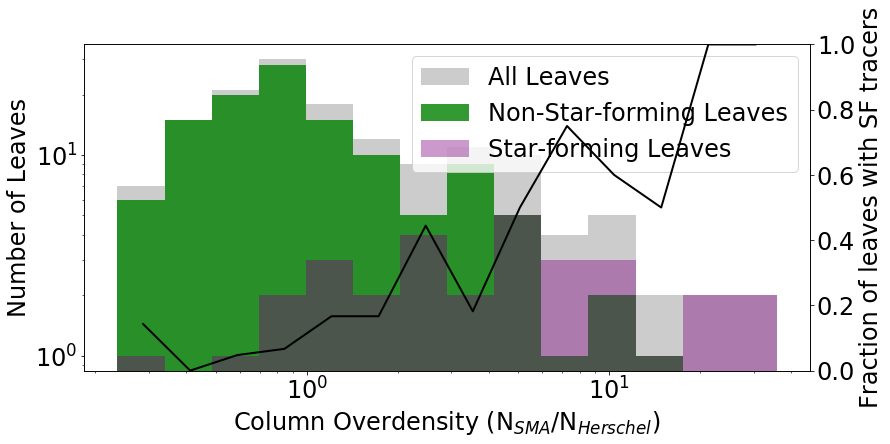

In [16]:
### make overdensity histogram with SF tracers

overdensity = np.array(catalog['N'],dtype=float) / np.array(catalog['ColumnDensity'],dtype=float)
overdensity[np.isnan(overdensity)]=0
#print overdensity
#print len(overdensity)
#print np.array(catalog['N'])
#print np.array(catalog['ColumnDensity'])
exclude_inds = np.where(overdensity != 0)
overdensity = overdensity[exclude_inds]

#all_tracers_2 = all_maser_2 + all_iryso_2 + all_HII_2
all_tracers_refined = sum_masers[exclude_inds]+sum_ir[exclude_inds]+sum_ysos[exclude_inds]
#print len(all_tracers_refined)

sf_cond_2 = (all_tracers_refined > 0)
nsf_cond_2 = (all_tracers_refined == 0)
 
#print len(nsf_cond_2)
#print len(np.array(overdensity))
#print len(np.array(overdensity)[nsf_cond_2])

plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16}) #set fontsize

# Plot Histogram
plt.rcParams.update({'font.size': 24}) #set fontsize
histfig = plt.figure(3,figsize=(13,6))
histfig.clf()
ax = histfig.gca()
plt.ylabel('Number of Leaves')
plt.xlabel('Column Overdensity (N$_{SMA}$/N$_{Herschel}$)')
#plt.legend(loc='upper left', shadow=False, fontsize=18)
#print overdensity
linbins = np.linspace(min(overdensity), max(overdensity),30)
logbins = np.logspace(np.log10(min(overdensity)), np.log10(max(overdensity)),15)
#print logbins
#print linbins
### histogram non sources
ax.set_xscale('log')
h1,l1,p1 = ax.hist(overdensity,bins=logbins, color='black',alpha=0.2, log=True,label='All Leaves')
h2,l2,p2 = ax.hist(overdensity[nsf_cond_2],bins=logbins, color='green',alpha=0.8, log=True,label='Non-Star-forming Leaves')
h3,l3,p3 = ax.hist(overdensity[sf_cond_2],bins=logbins, color='purple',alpha=0.4, log=True,label='Star-forming Leaves')
ax2 = ax.twinx()
midpts = (l1[:-1] + l1[1:])/2.
line_frac = ax2.plot(midpts, h3/h1, linestyle='-', color='k', linewidth=2.0, zorder=-21,label='Fraction of source pixels with SF tracers')
ax2.set_ylabel("Fraction of leaves with SF tracers")
ax2.set_ylim(0,1)
#fill = ax2.fill_between(midpts,h4/h2, color='red',alpha=0.3)
ax2.set_label('Fraction of leaves with SF tracers')
ax.legend()
plt.show()

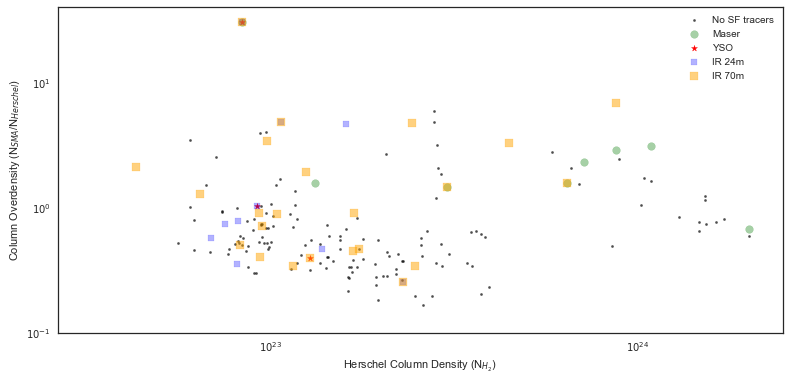

In [33]:
plt.close()
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16}) #set fontsize

### set up conditionals for excluded indices
overdensity = np.array(catalog['N'],dtype=float) / np.array(catalog['ColumnDensity'],dtype=float)
overdensity[np.isnan(overdensity)]=0
sum_ir = np.array(gutermuth)+np.array(molinari)
ir_24 = np.array(gutermuth)
ir_70 = np.array(molinari)
sum_ysos = np.array(an)+np.array(immer)+np.array(yusefZadeh)
sum_masers = np.array(caswell)+np.array(walsh)

none_cond_refined = (sum_ysos == 0) & (sum_masers == 0) & (sum_ir == 0) & (overdensity > 0)
maser_cond_refined = (sum_masers > 0) & (overdensity > 0)
yso_cond_refined = (sum_ysos > 0) & (overdensity > 0)
ir_24_cond_refined = (ir_24 > 0) & (overdensity > 0)
ir_70_cond_refined = (ir_70 > 0) & (overdensity > 0)

plt.rcParams.update({'font.size': 24}) #set fontsize
histfig = plt.figure(3,figsize=(13,6))
histfig.clf()
ax = histfig.gca()
plt.ylabel('Column Overdensity (N$_{SMA}$/N$_{Herschel}$)')
plt.xlabel('Herschel Column Density (N$_{H_2}$)')

ax.scatter(catalog['ColumnDensity'][none_cond_refined], overdensity[none_cond_refined],s=20, 
           color='black',marker='.',alpha=.7,label='No SF tracers')
ax.scatter(catalog['ColumnDensity'][maser_cond_refined], overdensity[maser_cond_refined],s=60, 
           color='forestgreen',marker='o',alpha=.4,label='Maser')
ax.scatter(catalog['ColumnDensity'][yso_cond_refined], overdensity[yso_cond_refined],s=40, 
           color='red',marker='*',alpha=1.,label='YSO')
ax.scatter(catalog['ColumnDensity'][ir_24_cond_refined], overdensity[ir_24_cond_refined],s=30, 
           color='blue',marker='s',alpha=.3,label='IR 24m')
ax.scatter(catalog['ColumnDensity'][ir_70_cond_refined], overdensity[ir_70_cond_refined],s=50, 
           color='orange',marker='s',alpha=.5,label='IR 70m')

ax.set_xscale("log")
ax.set_yscale("log")

ax.legend()
plt.show()

In [46]:
print catalog[0]

index    area_ellipse       area_exact      flux_integrated      major_sigma       minor_sigma       position_angle        radius              glon               glat              r_eff       testflux_integrated is_leaf      noise       flux_integrated_bgsub npix   mean_cont_flux  min_flux_integrated   peak_cont_flux    min_cont_flux   ColumnDensity        mass                  N                  Sigma                 n                   rho                 tff               glon_0           mass_bgsub    YSO HII Water Methanol  OH 8micron 24micron 70micron Notes sum_all sum_sf_tracers  Total_luminosity   Cool_luminosity   Warm_luminosity     Cool_dust_temp     H2CO_gas_temp   an2011_allysos caswell2012_allmmb gutermuth2015_all24m immer2012_allysos molinari2016_all70m walsh2014_allhops jusefZadeh2009_allysos
           arcsec2           arcsec2               Jy               arcsec            arcsec              deg              arcsec              deg                deg               

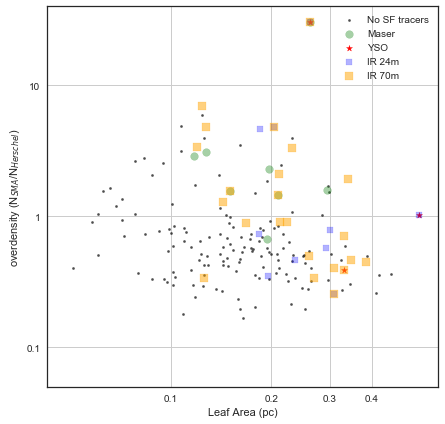

In [26]:
### Playing around with other scatter plots 
plt.close()
sns.set_style('white')
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 30}) #set fontsize

### set up conditionals for excluded indices
overdensity = np.array(catalog['N'],dtype=float) / np.array(catalog['ColumnDensity'],dtype=float)
overdensity[np.isnan(overdensity)]=0
sum_ir = np.array(gutermuth)+np.array(molinari)
ir_24 = np.array(gutermuth)
ir_70 = np.array(molinari)
sum_ysos = np.array(an)+np.array(immer)+np.array(yusefZadeh)
sum_masers = np.array(caswell)+np.array(walsh)

none_cond_refined = (sum_ysos == 0) & (sum_masers == 0) & (sum_ir == 0) & (overdensity > 0)
maser_cond_refined = (sum_masers > 0) & (overdensity > 0)
yso_cond_refined = (sum_ysos > 0) & (overdensity > 0)
ir_24_cond_refined = (ir_24 > 0) & (overdensity > 0)
ir_70_cond_refined = (ir_70 > 0) & (overdensity > 0)

plt.rcParams.update({'font.size': 30}) #set fontsize
histfig = plt.figure(3,figsize=(7,7))
histfig.clf()
ax = histfig.gca()
plt.xlabel('Leaf Area (pc)')# (N$_{SMA}$/N$_{Herschel}$)')
plt.ylabel('overdensity (N$_{SMA}$/N$_{Herschel}$)')

# quantity1 = catalog['r_eff']
# quantity2 = overdensity
quantity2 = overdensity
quantity1 = catalog['r_eff']*arcsec2pc

ax.scatter(quantity1[none_cond_refined], quantity2[none_cond_refined],s=20, 
           color='black',marker='.',alpha=.7,label='No SF tracers')
ax.scatter(quantity1[maser_cond_refined], quantity2[maser_cond_refined],s=60, 
           color='forestgreen',marker='o',alpha=.4,label='Maser')
ax.scatter(quantity1[yso_cond_refined], quantity2[yso_cond_refined],s=40, 
           color='red',marker='*',alpha=1.,label='YSO')
ax.scatter(quantity1[ir_24_cond_refined], quantity2[ir_24_cond_refined],s=30, 
           color='blue',marker='s',alpha=.3,label='IR 24m')
ax.scatter(quantity1[ir_70_cond_refined], quantity2[ir_70_cond_refined],s=50, 
           color='orange',marker='s',alpha=.5,label='IR 70m')

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(0.05,40)

plt.xticks([0.1,0.2,0.3,0.4],[0.1,0.2,0.3,0.4])
plt.yticks([0.1,1,10],[0.1,1,10])

ax.grid()

ax.legend()
plt.show()

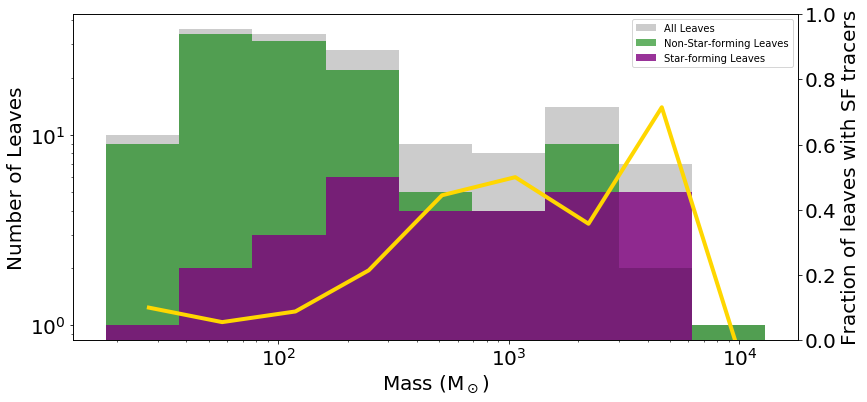

In [16]:
### make overdensity histogram with SF tracers
plt.close()
overdensity = np.array(catalog['N'],dtype=float) / np.array(catalog['ColumnDensity'],dtype=float)
overdensity[np.isnan(overdensity)]=0
#print overdensity
#print np.array(catalog['N'])
#print np.array(catalog['ColumnDensity'])
exclude_inds = np.where(overdensity != 0)
overdensity = overdensity[exclude_inds]

#all_tracers_2 = all_maser_2 + all_iryso_2 + all_HII_2
all_tracers_refined = sum_masers[exclude_inds]+sum_ir[exclude_inds]+sum_ysos[exclude_inds]

sf_cond_2 = (all_tracers_refined > 0)
nsf_cond_2 = (all_tracers_refined == 0)

#print len(np.array(overdensity)[nsf_cond_2])

plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16}) #set fontsize


### QUANTITY TO HISTOGRAM:
#OD_area = overdensity * catalog['area_exact'][exclude_inds]
OD_radius = overdensity * catalog['r_eff_pc'][exclude_inds]
hist_quantity = catalog['mass'][exclude_inds]#overdensity#OD_radius
###

# Plot Histogram
plt.rcParams.update({'font.size': 20}) #set fontsize
histfig = plt.figure(3,figsize=(13,6))
histfig.clf()
ax = histfig.gca()
plt.ylabel('Number of Leaves')
#plt.xlabel('Column Overdensity (N$_{SMA}$/N$_{Herschel}$) times leaf radius')
#plt.xlabel('Column Overdensity (N$_{SMA}$/N$_{Herschel}$)')
plt.xlabel('Mass (M$_\odot$)')

#plt.legend(loc='upper left', shadow=False, fontsize=18)
#print overdensity
linbins = np.linspace(min(hist_quantity), max(hist_quantity),30)
logbins = np.logspace(np.log10(min(hist_quantity)), np.log10(max(hist_quantity)),10)
#print logbins
#print linbins
### histogram non sources
ax.set_xscale('log')

h1,l1,p1 = ax.hist(hist_quantity,bins=logbins, color='black',alpha=0.2, log=True,label='All Leaves')
h2,l2,p2 = ax.hist(hist_quantity[nsf_cond_2],bins=logbins, color='green',alpha=0.6, log=True,label='Non-Star-forming Leaves')
h3,l3,p3 = ax.hist(hist_quantity[sf_cond_2],bins=logbins, color='purple',alpha=0.8, log=True,label='Star-forming Leaves')
ax2 = ax.twinx()
midpts = (l1[:-1] + l1[1:])/2.
line_frac = ax2.plot(midpts, h3/h1, linestyle='-', color='gold', linewidth=4.0, zorder=-21,label='Fraction of source pixels with SF tracers')
ax2.set_ylabel("Fraction of leaves with SF tracers")
ax2.set_ylim(0,1)
#fill = ax2.fill_between(midpts,h4/h2, color='red',alpha=0.3)
ax2.set_label('Fraction of leaves with SF tracers')
plt.rcParams.update({'font.size': 10})
ax.legend()
plt.show()

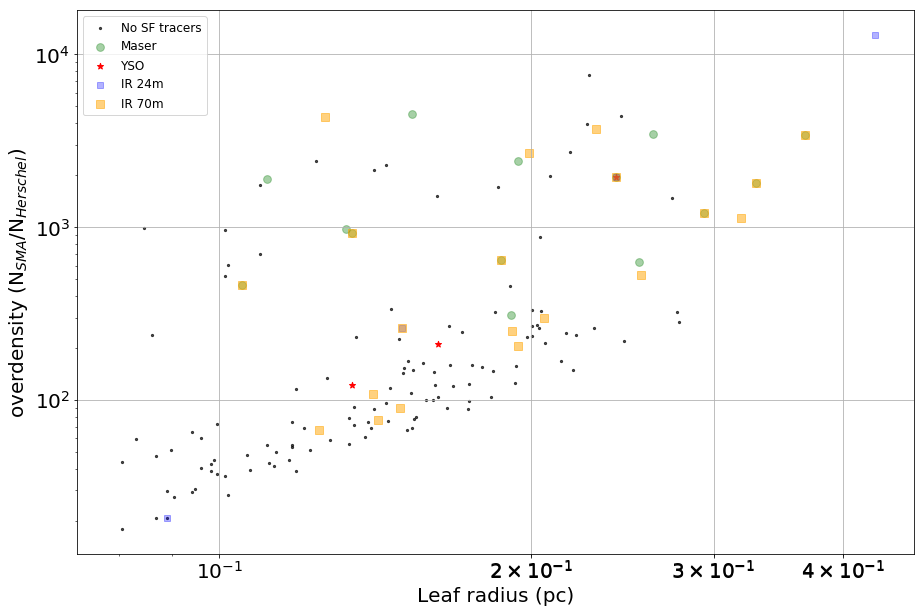

In [44]:
### Playing around with other scatter plots 
plt.close()
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 30}) #set fontsize

### set up conditionals for excluded indices
overdensity = np.array(catalog['N'],dtype=float) / np.array(catalog['ColumnDensity'],dtype=float)
overdensity[np.isnan(overdensity)]=0
ir_24 = catalog['24micron']
ir_70 = catalog['70micron']
sum_masers = catalog['water']+catalog['methanol']
sum_ysos = catalog['YSO']

none_cond_refined = (sum_ysos == 0) & (sum_masers == 0) & (sum_ir == 0) & (overdensity > 0)
maser_cond_refined = (sum_masers > 0) & (overdensity > 0)
yso_cond_refined = (sum_ysos > 0) & (overdensity > 0)
ir_24_cond_refined = (ir_24 > 0) & (overdensity > 0)
ir_70_cond_refined = (ir_70 > 0) & (overdensity > 0)

plt.rcParams.update({'font.size': 20}) #set fontsize
histfig = plt.figure(3,figsize=(15,10))
histfig.clf()
ax = histfig.gca()
plt.xlabel('Leaf radius (pc)')# (N$_{SMA}$/N$_{Herschel}$)')
plt.ylabel('overdensity (N$_{SMA}$/N$_{Herschel}$)')

# quantity1 = catalog['r_eff']
# quantity2 = overdensity
quantity2 = catalog['mass']#overdensity
quantity1 = catalog['r_eff_pc']#catalog['r_eff_pc']

ax.scatter(quantity1[none_cond_refined], quantity2[none_cond_refined],s=20, 
           color='black',marker='.',alpha=.7,label='No SF tracers')
ax.scatter(quantity1[maser_cond_refined], quantity2[maser_cond_refined],s=60, 
           color='forestgreen',marker='o',alpha=.4,label='Maser')
ax.scatter(quantity1[yso_cond_refined], quantity2[yso_cond_refined],s=40, 
           color='red',marker='*',alpha=1.,label='YSO')
ax.scatter(quantity1[ir_24_cond_refined], quantity2[ir_24_cond_refined],s=30, 
           color='blue',marker='s',alpha=.3,label='IR 24m')
ax.scatter(quantity1[ir_70_cond_refined], quantity2[ir_70_cond_refined],s=50, 
           color='orange',marker='s',alpha=.5,label='IR 70m')

ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_ylim(0.05,40)

plt.xticks([0.1,0.2,0.3,0.4])#,[0.1,0.2,0.3,0.4]) ### for radii
#plt.yticks([0.1,1,10])#,[0.1,1,10])

ax.grid()
plt.rcParams.update({'font.size': 12})
ax.legend(loc='best')
plt.show()